### Шаг 1. Откройте файл с данными и изучите общую информацию

В нашем распоряжении исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы. Нам нужно выявить определяющие успешность игры закономерности.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats as st

In [2]:
games = pd.read_csv('/datasets/games.csv')

In [3]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


#### Вывод по шагу 1.

Как мы видим, в имеющемся датасете пропущены часть пользовательских и экспертных рейтингов, не везде известен возрастной порог. Кроме того, рейтинг пользователей сохранен в формате object, а не float64. 

Возможные причины появления пропусков:
- во время выхода старых игр не было платформ для рецензирования как критиками, так и пользователями
- новым играм могли не успели выставить оценки
- некоторые игры оказалась слишком непопулярными, чтобы аккумулировать достаточный набор оценок

В то же время заполнить пропуски в рейтингах, не искажая общую картину, не представляется возможным, так как рейтинг конкретной игры не зависит от года выпуска или платформы.

<p style="color:green">Данные загружены и изучены, отлично</p>

### Шаг 2. Подготовьте данные

In [4]:
games.columns = map(str.lower, games.columns) # приводим названия столбцов к нижнему регистру

In [5]:
games['user_score'] = games['user_score'].replace({'tbd': None})
# значение TBD (to be determined) заменим пропусками, так как предуагадать пользовательский рейтинг игр, 
# не исказив общую картину, мы не можем
games['user_score'] = games['user_score'].astype('float') # приводим пользовательский рейтинг к типу данных float
games['user_score'] = 10 * games['user_score'] # приводим рейтинг критиков и геймеров к единой шкале

In [6]:
# добавляем столбец общих продаж
games['total_sales'] = games['na_sales'] + games['eu_sales'] + games['jp_sales'] + games['other_sales']
games.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,80.0,E,82.54
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,40.24
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,83.0,E,35.52
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,80.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,31.38


#### Вывод по шагу 2.

Добавлен столбец с общими продажами, типы данных приведены к нужному.

### Шаг 3. Проведите исследовательский анализ данных

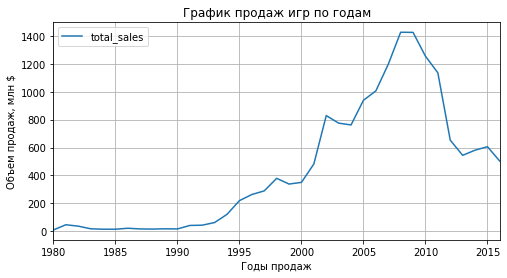

In [34]:
# построим график продаж игр
games_by_year = games.pivot_table(index='year_of_release', values='total_sales', aggfunc='count')
games_by_year.plot(grid=True, figsize=(8, 4))
plt.xlabel('Годы продаж')
plt.ylabel('Объем продаж, млн $')
plt.title('График продаж игр по годам')
plt.show()

Как мы видим, пик продаж пришелся на 2008-2009 гг.

In [8]:
# найдем платформы с наибольшими суммарными продажами
games_by_platform = games.pivot_table(index='platform', values='total_sales', aggfunc='sum')
games_by_platform.sort_values(by='total_sales', ascending=False).head(5)

,total_sales
platform,
PS2,1255.77
X360,971.42
PS3,939.65
Wii,907.51
DS,806.12


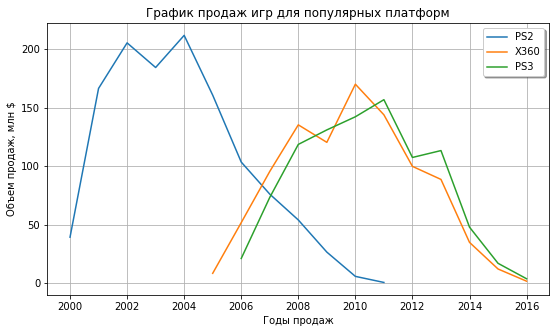

In [46]:
# найдем распределение продаж по годам для трёх самых популярных платформ
fig, ax = plt.subplots(figsize=(9,5))
for i in ['PS2', 'X360', 'PS3']:
    popular_games = games.loc[games['platform'] == i]
    popular_by_year = popular_games.pivot_table(index='year_of_release', values='total_sales', aggfunc='sum')
    ax.plot(popular_by_year, label=i)
    ax.grid()
legend = ax.legend(loc='upper right', shadow=True)
plt.xlabel('Годы продаж')
plt.ylabel('Объем продаж, млн $')
plt.title('График продаж игр для популярных платформ')
plt.show()

Как можно видеть из графика, срок популярности платформы от появления на рынке до резкого снижения популярности составляет около 5-6 лет. Данный показатель и будем считать <b>актуальным периодом</b>.

Кроме того, из графика видно, что популярность моделей, на смену которым пришли новые (PS4 вместо PS3, XOne вместо X360 и т.д.) упала почти до нуля.

In [10]:
new_games = games.query('year_of_release > 2011') # оставим только данные за актуальный период, с 2012 по 2016 год.

In [11]:
# выясним объем продаж по платформам за актуальный период
new_games_by_platform = new_games.pivot_table(index='platform', values='total_sales', aggfunc='sum')
new_games_by_platform.sort_values(by='total_sales', ascending=False)

,total_sales
platform,
PS4,314.14
PS3,288.79
X360,236.54
3DS,194.61
XOne,159.32
WiiU,82.19
PC,62.65
PSV,49.18
Wii,35.37


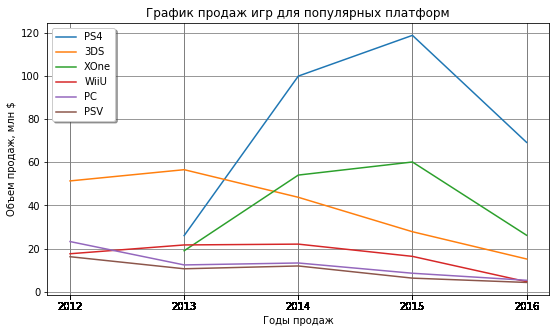

In [37]:
# найдем распределение продаж по годам для самых популярных платформ за последние 5 лет, исключая устаревшие
fig, ax = plt.subplots(figsize=(9,5))
for i in ['PS4', '3DS', 'XOne', 'WiiU', 'PC', 'PSV']: # из списка платформ убираем PS3, X360, PSP, Wii и DS
    i_games = new_games.loc[new_games['platform'] == i]
    i_by_year = i_games.pivot_table(index='year_of_release', values='total_sales', aggfunc='sum')
    ax.grid(color = 'gray')
    ax.plot(i_by_year, label=i)
legend = ax.legend(loc='upper left', shadow=True)
plt.xticks(new_games['year_of_release'])
plt.xlabel('Годы продаж')
plt.ylabel('Объем продаж, млн $')
plt.title('График продаж игр для популярных платформ')
plt.show()

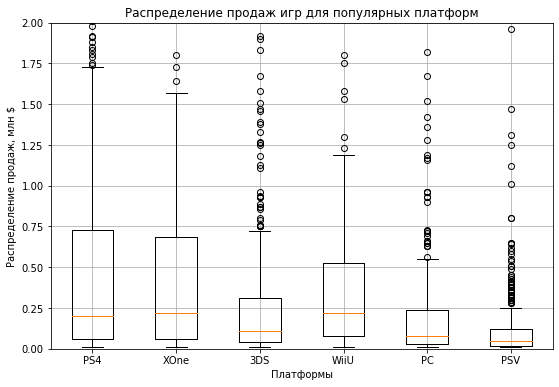

In [13]:
# построим "ящики с усами" для популярных платформ, исключая устаревшие
fig = plt.figure(1, figsize=(9, 6))
ax = fig.add_subplot(111)
ax.grid()
data_to_plot = [new_games.loc[new_games['platform'] == "PS4", 'total_sales'], new_games.loc[new_games['platform'] == "XOne", 
        'total_sales'], new_games.loc[new_games['platform'] == "3DS", 'total_sales'],
        new_games.loc[new_games['platform'] == "WiiU", 'total_sales'],
        new_games.loc[new_games['platform'] == "PC", 'total_sales'], 
        new_games.loc[new_games['platform'] == "PSV", 'total_sales']]
plt.ylim(0, 2)
ax.set_xticklabels(['PS4', 'XOne', '3DS', 'WiiU', "PC", 'PSV'])
plt.xlabel('Платформы')
plt.ylabel('Распределение продаж, млн $')
plt.title('Распределение продаж игр для популярных платформ')
bp = ax.boxplot(data_to_plot)

Вывод: платформы PS4, XOne и WiiU имеют самые высокие медианные показатели, при этом у первых двух самые высокие уровни третьего квартиля. Теперь сравним наши показатели со средними продажами.

In [14]:
new_games_grouped = new_games.pivot_table(index='platform', values='total_sales', aggfunc='mean')
new_games_grouped.sort_values(by='total_sales', ascending=False)

,total_sales
platform,
X360,0.810068
PS4,0.801378
Wii,0.655000
XOne,0.645020
PS3,0.585781
WiiU,0.559116
3DS,0.491439
DS,0.404839
PC,0.250600


Вывод: средние продажи игр на PS4 заметно превышают аналогичный показатель для XOne. 
Однако это не должно вводить нас в заблуждение: как видно из графика, это достигается из-за наличия "тяжёлых" выбросов, лежащих поверх "усов" - игр-суперхитов с большими продажами. Для большей же части игр распределение продаж на PS4 и XOne одинаково.

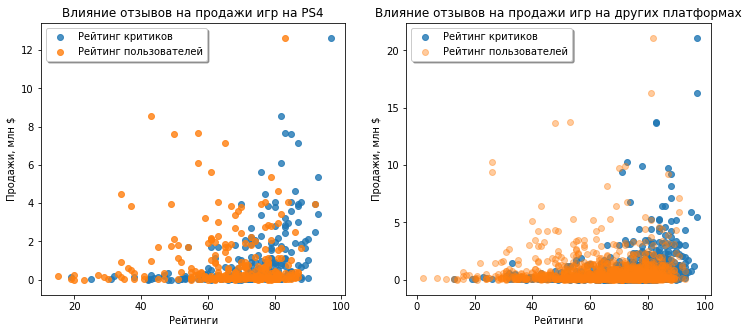

In [44]:
# выясним корреляцию отзывов критиков и геймеров и продаж игр, сначала для самой популярной платформы, а затем для остальных
fig = plt.figure(figsize=(12, 5))
area = fig.add_subplot(1, 2, 1)
ps4_games = new_games.loc[new_games['platform'] == 'PS4']
plt.scatter(ps4_games['critic_score'], ps4_games['total_sales'], alpha=0.8, label='Рейтинг критиков')
plt.scatter(ps4_games['user_score'], ps4_games['total_sales'], alpha=0.8, label='Рейтинг пользователей')
plt.xlabel('Рейтинги')
plt.ylabel('Продажи, млн $')
plt.legend(loc='upper left', shadow=True)
plt.title('Влияние отзывов на продажи игр на PS4')

area = fig.add_subplot(1, 2, 2)
non_ps4_games = new_games.loc[new_games['platform'] != 'PS4']
plt.scatter(non_ps4_games['critic_score'], non_ps4_games['total_sales'], alpha=0.8, label='Рейтинг критиков')
plt.scatter(non_ps4_games['user_score'], non_ps4_games['total_sales'], alpha=0.4, label='Рейтинг пользователей')
plt.xlabel('Рейтинги')
plt.ylabel('Продажи, млн $')
plt.legend(loc='upper left', shadow=True)
plt.title('Влияние отзывов на продажи игр на других платформах')
plt.show()

In [16]:
print('Корреляция продаж и рейтинга критиков для PS4 составляет', ps4_games['critic_score'].corr(ps4_games['total_sales']))
print('Корреляция продаж и рейтинга пользователей для PS4 составляет', ps4_games['user_score'].corr(ps4_games['total_sales']))
print()
print('Корреляция продаж и рейтинга критиков для других платформ составляет', non_ps4_games['critic_score'].corr(non_ps4_games['total_sales']))
print('Корреляция продаж и рейтинга пользователей для других платформ составляет', non_ps4_games['user_score'].corr(non_ps4_games['total_sales']))

Корреляция продаж и рейтинга критиков для PS4 составляет 0.40656790206178095
Корреляция продаж и рейтинга пользователей для PS4 составляет -0.031957110204556445

Корреляция продаж и рейтинга критиков для других платформ составляет 0.2847728298723546
Корреляция продаж и рейтинга пользователей для других платформ составляет 0.009513048660603471


Вывод: рейтинг критиков существенно влияет на продажи игры, в то время как влияние рейтинга пользователей фактически отсутствует. При этом влияние критиков на продажи игр на PS4 больше, чем на других платформах.

In [17]:
# узнаем общее распределение игр по жанрам
new_games_genres = new_games.pivot_table(index='genre', values='name', aggfunc='count')
new_games_genres.sort_values(by='name', ascending=False).head()

,name
genre,
Action,1031
Role-Playing,370
Adventure,302
Sports,268
Shooter,235


Вывод: в актуальный период больше всего производилось игр в жанрах action, RPG и adventure.

In [18]:
# узнаем общие продажи по жанрам
new_games_genres = new_games.pivot_table(index='genre', values='total_sales', aggfunc='sum')
new_games_genres.sort_values(by='total_sales', ascending=False).head(5)

,total_sales
genre,
Action,441.12
Shooter,304.73
Role-Playing,192.80
Sports,181.07
Misc,85.04


Вывод: в актуальный период самыми прибыльными по общей выручке жанрами стали action, shooter и RPG.

In [19]:
new_games_genres = new_games.pivot_table(index='genre', values='total_sales', aggfunc='mean')
new_games_genres.sort_values(by='total_sales', ascending=False)

,total_sales
genre,
Shooter,1.296723
Platform,0.717647
Sports,0.675634
Role-Playing,0.521081
Racing,0.465217
Misc,0.442917
Simulation,0.439000
Action,0.427856
Fighting,0.408165


Вывод: при этом на единицу игры больше всего денег принесли шутеры, платформеры и спортивные игры. Наименее прибыльными играми стали стратегии, головоломки и adventure.

#### Вывод по шагу 3.

Мы выяснили, что:
- срок популярности платформ в среднем составляет около 5-6 лет, после чего выходит новое поколение консолей, а продажи на старом стремительно падают
- на 2016 год самыми популярными платформами являются PS4, Xbox One и Nintendo 3DS, однако продажи игр на всех платформах падают
- из актуальных платформ лучшие медианные показатели продаж - у PS4, Xbox One и WiiU
- продажи игр в большой степени зависят от отзывов критиков и почти не зависят от отзывов пользователей

### Шаг 4. Составьте портрет пользователя каждого региона

In [20]:
# подсчитаем суммарные продажи игр по каждому региону
na_total_sales = new_games['na_sales'].sum()
eu_total_sales = new_games['eu_sales'].sum()
jp_total_sales = new_games['jp_sales'].sum()
other_total_sales = new_games['other_sales'].sum()
world_total_sales = new_games['total_sales'].sum()

In [21]:
# выясним среднюю долю каждого региона в мировых продажах
na_avg_share = na_total_sales / world_total_sales
eu_avg_share = eu_total_sales / world_total_sales
jp_avg_share = jp_total_sales / world_total_sales
other_avg_share = other_total_sales / world_total_sales

In [22]:
# выясним, насколько продажи конкретной игры в каждом регионе отличаются от средних для данного региона

new_games.loc[:,'na_dif'] = new_games.loc[:,'na_sales'] / new_games.loc[:,'total_sales'] - na_avg_share
new_games.loc[:,'eu_dif'] = new_games.loc[:,'eu_sales'] / new_games.loc[:,'total_sales'] - eu_avg_share
new_games.loc[:,'jp_dif'] = new_games.loc[:,'jp_sales'] / new_games.loc[:,'total_sales'] - jp_avg_share
new_games.loc[:,'other_dif'] = new_games.loc[:,'other_sales'] / new_games.loc[:,'total_sales'] - other_avg_share

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [23]:
# выясним, в каком регионе фактическая доля продаж сильнее всего превысила среднюю. 
# опираясь на этот показатель, присвоим каждой игре приоритетный для нее регион 
def what_region(row): 
    max_dif = max(row['na_dif'], row['eu_dif'], row['jp_dif'], row['other_dif'])
    if max_dif == row['na_dif']:
        return 'NA'
    if max_dif == row['eu_dif']:
        return 'EU'
    if max_dif == row['jp_dif']:
        return 'JP'
    if max_dif == row['other_dif']:
        return 'other'
new_games.loc[:, 'region'] = new_games.apply(what_region, axis=1)

In [24]:
# определим самые популярные платформы для каждого региона
for i in ['EU', 'JP', "NA"]:
    i_new_games = new_games.loc[new_games['region'] == i]
    i_new_games_by_region = i_new_games.pivot_table(index=('region', 'platform'), values='total_sales', aggfunc='sum')
    print(i_new_games_by_region.sort_values(by='total_sales', ascending=False).head(5))

                 total_sales
region platform             
EU     PS4            221.10
       PS3            138.86
       PC              57.08
       X360            39.44
       XOne            24.90
                 total_sales
region platform             
JP     3DS            164.44
       PS3             48.79
       WiiU            30.16
       PSV             27.99
       PS4             13.19
                 total_sales
region platform             
NA     X360           196.77
       XOne           134.41
       PS3             55.31
       WiiU            42.88
       PS4             35.93


In [25]:
# определим самые популярные жанры для каждого региона
for i in ['EU', 'JP', "NA"]:
    i_new_games = new_games.loc[new_games['region'] == i]
    i_new_games_by_region = i_new_games.pivot_table(index=('region', 'genre'), values='total_sales', aggfunc='sum')
    print(i_new_games_by_region.sort_values(by='total_sales', ascending=False).head(5))

                     total_sales
region genre                    
EU     Action             178.61
       Shooter            114.95
       Sports              82.11
       Racing              40.79
       Role-Playing        36.12
                     total_sales
region genre                    
JP     Role-Playing       123.24
       Action              61.66
       Platform            26.25
       Misc                20.97
       Simulation          20.47
                     total_sales
region genre                    
NA     Action             165.87
       Shooter            138.81
       Sports              85.47
       Misc                46.82
       Role-Playing        25.82


In [26]:
# переведем буквенные показатели рейтинга ESRB в численные показатели, увеличивая индекс по мере возрастания строгости рейтинга
new_games.loc[:, 'rating'] = new_games.loc[:,'rating'].replace({'E': 0, 'E10+': 1, 'T': 2, 'M': 3})

In [27]:
# подсчитаем корреляцию рейтинга ESRB и объема продаж для каждого региона
for i in ['EU', 'JP', "NA"]:
    i_new_games = new_games.loc[new_games['region'] == i]
    print('В регионе', i, 'корреляция рейтинга ESRB и продаж составляет', i_new_games['rating'].corr(i_new_games['total_sales']))

В регионе EU корреляция рейтинга ESRB и продаж составляет 0.13511216255450062
В регионе JP корреляция рейтинга ESRB и продаж составляет -0.34531458317003
В регионе NA корреляция рейтинга ESRB и продаж составляет 0.10086072888675086


#### Вывод по шагу 4:
- предпочтения платформ сильно зависят от региона: в Северной Америке с отрывом лидируют платформы семейства Xbox, в Европе - семейства Sony Playstation, а в Японии безусловный лидер - Nintendo 3DS.
- жанровые предпочтения в Европе и Северной Америке примерно одинаковые (экшены, шутеры, спортивные игры), в то время как в Японии популярность жанров смещена в сторону RPG, а также малопопулярых в Европе и Америке жанров - платформеров и симуляторов.
- в Европе и Северной Америке рейтинг ESRB мало влияет на продажи игр, в то время как в Японии ужесточение рейтинга резко снижает продажи игры.

### Шаг 5. Проверьте гипотезы

Проверим нулевую гипотезу о равенстве среднего двух генеральных совокупностей по взятым из них выборкам: средние пользовательские рейтинги платформы XOne равны средним пользовательским рейтингам платформы PC. Альтернативная гипотеза: эти показатели неравны.

In [28]:
# оставим только игры с указанным пользовательским рейтингом
rated_new_games = new_games.copy()
rated_new_games.dropna(subset = ['user_score'], inplace=True)

In [29]:
pc_user_score = rated_new_games.loc[new_games['platform']=='PC', 'user_score']
xone_user_score = rated_new_games.loc[new_games['platform']=='XOne', 'user_score']

alpha = 0.05 # задаём стандартный критический уровень статистической значимости

results = st.ttest_ind(pc_user_score, xone_user_score) # проверяем гипотезу о равенстве средних двух независимых совокупностей

print('p-значение:', results.pvalue) # выводим на экран получившееся p-значение

if (results.pvalue < alpha): # сравниваем получившееся p-значение с заданным уровнем статистической значимости):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.5535080500643805
Не получилось отвергнуть нулевую гипотезу


In [30]:
print('Средний пользовательский рейтинг для платформы PC равен', pc_user_score.mean())
print('Средний пользовательский рейтинг для платформы Xone равен', xone_user_score.mean())

Средний пользовательский рейтинг для платформы PC равен 64.2864077669903
Средний пользовательский рейтинг для платформы Xone равен 65.21428571428571


И действительно, разница между рейтингами мала и с вероятность 55% может быть случайной.

Теперь проверим нулевую гипотезу о равенстве среднего двух генеральных совокупностей по взятым из них выборкам: средние пользовательские рейтинги жанра Action равны средним пользовательским рейтингам жанра Sports. Альтернативная гипотеза: эти показатели неравны.

In [31]:
action_user_score = rated_new_games.loc[new_games['genre']=='Action', 'user_score']
sports_user_score = rated_new_games.loc[new_games['genre']=='Sports', 'user_score']

alpha = 0.05 # задаём стандартный критический уровень статистической значимости

results = st.ttest_ind(action_user_score, sports_user_score) # проверяем гипотезу о равенстве средних двух независимых совокупностей

print('p-значение:', results.pvalue) # выводим на экран получившееся p-значение

if (results.pvalue < alpha): # сравниваем получившееся p-значение с заданным уровнем статистической значимости):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 3.7163089460930885e-26
Отвергаем нулевую гипотезу


In [32]:
print('Средний пользовательский рейтинг для жанра Action равен', action_user_score.mean())
print('Средний пользовательский рейтинг для жанра Sports равен', sports_user_score.mean())

Средний пользовательский рейтинг для жанра Action равен 68.25047801147228
Средний пользовательский рейтинг для жанра Sports равен 54.55897435897436


И действительно, разница между средними рейтингами этих жанров слишком велика, чтобы быть случайной.

#### Вывод по шагу 5.

Мы доказали, что пользовательские рейтинги платформ PC и XOne примерно одинаковы, а рейтинги игр в жанре экшен на статистически достоверном уровне отличаются от рейтинга спортивных игр.

### Общий вывод

В ходе исследования мы выяснили, что на объем продаж игры влияют следующие факторы:

- конъюнктура рынка (в настоящий момент продажи игр на всех платформах падают)
- платформа игры (актуальными платформами на настоящий момент являются PS4, Xbox One, WiiU и 3DS)
- рейтинг критиков (а вот отзывы пользователей почти не влияют)
- жанр игры (самыми прибыльными являются шутеры, спортивные игры и платформеры)
- регион продвижения игры:
    - в Северной Америке играют на Xbox, Европе - на Sony Playstation, Японии - на Nintendo 3DS (при этом традиционные для российских геймеров PC на заметном уровне присутствуют лишь в Европе)
    - в Европе и Америке любят экшены, шутеры и спортивные игры, а в Японии - RPG (включая, очевидно, jRPG), экшены и платформеры
- в некоторых регионах (Япония) жёсткий возрастнйо рейтинг заметно снижает продажи игр

При этом мы также доказали, что для пары PC-Xbox One средний рейтинг игры не зависит от платформы, а отдельные жанры имеют рейтинг, статистически значимо более высокий, чем другие (например, экшены получают более высокую оценку, чем спортивные игры).